# Optimal Transport Project
## Robust reinforcement learning with Wasserstein constraint

### Clémence GRISLAIN

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil, pi
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from time import time
from scipy.linalg import sqrtm
from statistics import mean
from tqdm import trange

Let $\pi$ be a fixed policy determined by a parameter $\theta$, in this project, we are only interested in finding the worst case transition model parametrised by $\phi$ within the Wasserstein ball centered in the resference transition model parametrised by $\phi_0$.

This minimisation problem can be written:

$$
\underset{\phi}{\text{min }}\mathbb{E}_{\tau \sim p^\phi_\theta(.)}\left[R_{total}(\tau) \right]
$$
$$ 
\text{s.t }\underbrace{ \mathbb{E}_{(s,a)\sim\pi(.) \rho_\pi^{\phi_0}(.)} \left[\mathcal{W}^2_2 \left( \mathcal{P}_\phi(.|s,a), \mathcal{P}_{\phi_0}(.|s,a) \right) \right]}_{W(\phi)} \leq \epsilon
$$

where $p^\phi_\theta(\tau)$ is the trajectory density function (parametrised both by $\theta$ and $\phi$)

$ p^\phi_\theta(\tau)=\mu_0(s_o)\pi_\theta(a_0|s_0) \overset{T-1}{\underset{t=1}{\prod}} \mathcal{P}_\phi(s_{t+1}|s_t,a_t)\pi_\theta(a_t|s_t)$

### 1. Problem approximation

Second order  

$$
W(\phi) \approx W(\phi_0) + \nabla_\phi W(\phi_0)^T(\phi - \phi_0) + \frac{1}{2}(\phi - \phi_0)^T\nabla^2_\phi W(\phi_0)(\phi-\phi_0) 
$$
and we have
*  $ W(\phi_0) = 0$ by definition
*  $\nabla_\phi W(\phi_0) = 0$ as $\phi_0$ minimises $W$
$$ 
W(\phi)\approx \frac{1}{2}(\phi - \phi_0)^T\nabla^2_\phi W(\phi_0)(\phi-\phi_0) 
$$

The problem can be rewritten as:

$$
\underset{\phi}{\text{min }}\mathbb{E}_{\tau \sim p^\phi_\theta}(\tau)\left[R_{total}(\tau) \right]
$$
$$ 
\frac{1}{2}(\phi - \phi_0)^T\underbrace{\nabla^2_\phi W(\phi_0)}_{H_0}(\phi-\phi_0) \leq \epsilon
$$

**Remark:** $H_0$ can be computed based only on the reference dynamics $\phi_0$ and any behavioral policy (it is given as an input in the paper's algorithm).

This is a quadratic contrained problem and can be solved by:
1.  using interior-point-method
2.  approximating the loss with first-order expansion which leads to an iterative closed form solution:
  $$\phi_{j+1}=\phi_0 - \sqrt{\frac{2\epsilon}{g_j^T H_0^{-1}g_j}}H_0^{-1}g_j$$
  where $g_j = \nabla_\phi \mathbb{E}_{\tau \sim p^{\phi_j}_\theta(\tau)}[R_{total}(\tau)]$ 

### 2. Computing $g_j$ and $H_0$

Zero-Order Gradient Estimate

$$g_j = \nabla_\phi \mathbb{E}_{\tau \sim p^{\phi_j}_\theta(\tau)}[R_{total}(\tau)]=\frac{1}{\sigma^2}\mathbb{E}_{\xi \sim \mathcal{N}(0,\sigma^2I)}\left[\xi \underbrace{\int_\tau p_\theta^{\phi_j + \xi}(\tau)R_{total}(\tau)d\tau}_{\mathbb{E}_{\tau \sim p_\theta^{\phi_j + \xi}(.)}[R_{total}(\tau)]} \right]$$

Zero-order Hessian Estimate

$$ 
H_0
=\nabla_\phi^2\mathbb{E}_{(s,a)\sim\pi(.)\rho_\pi^{\phi_0}(.)}\left[\underbrace{\mathcal{W}^2_2\left(\mathcal{P}_\phi(.|s,a),\mathcal{P}_{\phi_0}(.|s,a)\right)}_{\mathcal{W}_{(s,a)}(\phi)} \right] |_{\phi=\phi0}
= \frac{1}{\sigma^2}\mathbb{E}_{\xi \sim \mathcal{N}(0, \sigma^2I)}\left[\frac{1}{\sigma^2}\xi (\mathbb{E}_{(s,a)\sim\pi(.)\rho^{\phi_0}_{\pi}(.)}[\mathcal{W}_{(s,a)}(\phi_0 + \xi)])\xi^T - \mathbb{E}_{(s,a)\sim \pi(.)\rho^{\phi_0}_\pi(.)}[\mathcal{W}_{(s,a)}(\phi_0+\xi)]I
\right]
$$

We will only work on the computation of $H_0$ to focus on optimal transport.

## Part I. Wasserstein distance Hessian

### Minimisation on a Wasserstein ball

In this part, we consider the minimisation problem out of the application to 

Reinforcement Learning. In this context, the problem can be witten:

$$
\underset{\phi}{\text{min }}R(\phi)
$$
$$ 
\text{s.t }\underbrace{ \mathcal{W}^2_2 \left( \mathcal{P}_\phi(.), \mathcal{P}_{\phi_0}(.) \right)}_{W(\phi)} \leq \epsilon
$$ 
 Approximated to
$$
\underset{\phi}{\text{min }}R(\phi)
$$
$$ 
\frac{1}{2}(\phi - \phi_0)^T\underbrace{\nabla^2_\phi W(\phi_0)}_{H_0}(\phi-\phi_0) \leq \epsilon
$$

With reasonnings similar to the article, we use the Zero-order approximation of the Hessian:

$$ 
H_0
= \frac{1}{\sigma^2}\mathbb{E}_{\xi \sim \mathcal{N}(0, \sigma^2I)}\left[\frac{1}{\sigma^2}\xi (W(\phi_0 + \xi))\xi^T - W(\phi_0+\xi)I
\right]
$$

and the closed-form solution

  $$\phi_{j+1}=\phi_0 - \sqrt{\frac{2\epsilon}{g_j^T H_0^{-1}g_j}}H_0^{-1}g_j$$

where $g_j = \nabla_\phi R_{total}(\phi_j
)$ 

### Gaussian dynamics

We consider the following problem on $\mathbb{R}^d$

*  $\mathcal{P}_{\phi=(\mu, \sigma)}(.) \sim \mathcal{N}_d(\mu, diag(\sigma^2))$
*  reference dynamics $\phi_0 = (\mu_0, \sigma_0)=(0_d, 1_d)$

In [ ]:
dim = 2

mu_0 = np.zeros(dim)
sigma_0 = np.ones(dim)
cov_0 = np.diag(sigma_0*sigma_0)

mu_x = np.random.uniform(-10, 10, dim)
sigma_x = np.random.uniform(0, 10, dim)
cov_x = np.diag(sigma_x*sigma_x)

phi_0 = np.concatenate([mu_0, sigma_0]).reshape(2*dim, 1) #in R^2d
phi_x = np.concatenate([mu_x, sigma_x]).reshape(2*dim, 1)

In [ ]:
phi_x

array([[-7.06723848],
       [ 6.25942977]])

The Wasserstein distribution between two Gaussian distributions in $\mathbb{R}^d$, $\alpha \sim \mathcal{N}_d(\mu_\alpha, \Sigma_\alpha)$ and $\beta \sim \mathcal{N}_d(\mu_\beta, \Sigma_\beta)$, can be computed thanks to the formula:

$$
\mathcal{W}^2_2(\alpha, \beta)=||\mu_\alpha - \mu_\beta||^2 + \mathcal{B}(\Sigma_\alpha, \Sigma_\beta)^2
$$
Where $\mathcal{B}$ is the Bures's mectric defined as 

$$
\mathcal{B}(\Sigma_\alpha, \Sigma_\beta)^2 = tr(\Sigma_\alpha + \Sigma_\beta - 2\times(\Sigma_\alpha^{\frac{1}{2}} \Sigma_\beta \Sigma_\alpha^{\frac{1}{2}})^{\frac{1}{2}})
$$
\
In our case, $\Sigma_\alpha = \text{diag}(\sigma_\alpha^2)$ and $\Sigma_\beta=\text{diag}(\sigma_\beta^2)$

$$
\mathcal{B}(\Sigma_\alpha, \Sigma_\beta) = ||\sigma_\alpha - \sigma_\beta||_2
$$

Finally,

$$
\mathcal{W}_2^2(\alpha, \beta) = ||\mu_\alpha - \mu_\beta||_2 + ||\sigma_\alpha - \sigma_\beta||_2 = ||\phi_\alpha - \phi_\beta||_2
$$

where $\phi = (\mu, \sigma)$

In [ ]:
def Bures(cov_alpha, cov_beta):
  return np.trace(cov_alpha + cov_beta - 2*sqrtm(sqrtm(cov_alpha)@cov_beta@sqrtm(cov_alpha)))

In [ ]:
def gauss_Wass(mu_alpha, mu_beta, cov_alpha, cov_beta):
  return np.linalg.norm(mu_alpha - mu_beta)**2 + Bures(cov_alpha, cov_beta)

In [ ]:
def W_true(mu_x, cov_x):
  return gauss_Wass(mu_x, mu_0, cov_x, cov_0)

In [ ]:
def W_diag(mu_x, sigma_x):
  return np.linalg.norm(mu_x - mu_0)**2 + np.linalg.norm(sigma_x - sigma_0)**2

In [ ]:
def W_phi(phi):
  return np.linalg.norm(phi-phi_0)**2

### Discrete approximation for continuous measures

We approximate the Wasserstein distance on the continuous distributions $\mathcal{P}_\phi(.|s,a)$ and $\mathcal{P}_{\phi_0}(.|s,a)$ by the Wasserstein distance on the discrete distributions respectivelly sampled from $\mathcal{P}_\phi(.|s,a)$ and $\mathcal{P}_{\phi_0}(.|s,a)$.
*  $\alpha = \frac{1}{n}\sum_{i=1}^n\delta_{x_i}$ where $x_i$ are identically and independently distributed according to $\mathcal{P}_\phi(.|s,a)$
*  $\beta = \frac{1}{n}\sum_{i=j}^n\delta_{y_j}$ where $y_i$ are identically and independently distributed according to $\mathcal{P}_{\phi_0}(.|s,a)$

which leads to
$$\mathcal{W}^2_2\left(\mathcal{P}_\phi(.|s,a),\mathcal{P}_{\phi_0}(.|s,a) \right) \approx \mathcal{W}^2_2\left(\alpha, \beta \right)$$

##### Discrete approximation

In [ ]:
n = 100

X0 = np.random.multivariate_normal(mu_0, cov_0, n)

X = np.random.multivariate_normal(mu_x, cov_x, n)

b = 1./n * np.ones((n, 1))
b0 = 1./n * np.ones((n, 1))

In [ ]:
counts, bins = np.histogram(X0)
plt.hist(bins[:-1], bins, weights=counts, density = True)
counts, bins = np.histogram(X)
plt.hist(bins[:-1], bins, weights=counts, density = True, color='cyan')

x = np.linspace(-10,10,100)
Y0 = 1/(np.sqrt(2*pi*sigma_0*sigma_0))*np.exp(-0.5*((x-mu_0)/sigma_0)**2)
Y = 1/(np.sqrt(2*pi*sigma_x*sigma_x))*np.exp(-0.5*((x-mu_x)/sigma_x)**2)
plt.plot(x, Y, c='red', linewidth=2)
plt.plot(x, Y0, c='black', linewidth=3)

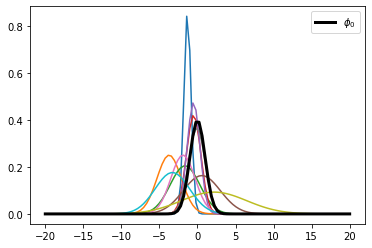

In [ ]:
from math import pi

if dim==1:
  for _ in range(10):
    mu_x = np.random.normal(0, 2, dim)
    sigma_x = np.random.normal(1, 2, dim)
    
    X = np.linspace(-20,20,100)
    Y = 1/(np.sqrt(2*pi*sigma_x*sigma_x))*np.exp(-0.5*((X-mu_x)/sigma_x)**2)

    plt.plot(X,Y)

Y = 1/(np.sqrt(2*pi*sigma_0*sigma_0))*np.exp(-0.5*((X-mu_0)/sigma_0)**2)
plt.plot(X,Y,c='black', label="$\phi_0$", linewidth=3)
plt.legend();

##### Compute $\mathcal{W}^2_2 \left( \mathcal{P}_\phi(.),\mathcal{P}_{\phi_0}(.)\right)$ - Wasserstein distance between two **discrete** dynamics

In [ ]:
# ||x-y||^2 map
def distmat(x,y):
    return np.sum(x**2,0)[:,None] + np.sum(y**2,0)[None,:] - 2*x.transpose().dot(y)

# Compute wasserstein distance
def solve(X, X0, b, b0, LOG=False):
  n, m = len(X[0]), len(X0[0])

  # weights matrix
  C = distmat(X, X0)

  # define optimisation variable P
  P_OT = cp.Variable((n,m))

  # set of discrete coupling
  u = np.ones((m,1))
  v = np.ones((n,1))
  U = [0 <= P_OT, cp.matmul(P_OT,u)==b, cp.matmul(P_OT.T,v)==b0]

  # solve using CVXP
  objective = cp.Minimize(cp.sum(cp.multiply(P_OT,C)) )
  prob = cp.Problem(objective, U)
  result = prob.solve()

  # number of non-zero
  if LOG:
    print("(n,m): ({},{})".format(n, m))
    print("Number of non-zero: %d (n + m-1 = %d)" %(len(P_OT.value[P_OT.value>1e-5]), n + m-1))

  return P_OT, np.sum((P_OT.value) * C)

In [ ]:
P_OT, obj = solve(X.T, X0.T, b, b0, LOG=True)
print("Estimate Wasserstein distance", np.round(obj, 4))
print("True Wasserstein distance", np.round(W_phi(phi_x), 4))

(n,m): (100,100)
Number of non-zero: 100 (n + m-1 = 199)
Estimate Wasserstein distance 283.7137
True Wasserstein distance 251.5311


This turns to be a Monge problem with $n$ variables in $\mathbb{R}^d$. The optimal transport is a stochastic matrix on all directions.

In [ ]:
def W_Discrete(phi, n=100):

  mu = phi[:dim].reshape(dim,)
  sigma = phi[dim:].reshape(dim,)
  cov = np.diag(sigma*sigma)
  X0 = np.random.multivariate_normal(mu, cov, n)

  X = np.random.multivariate_normal(mu_0, cov_0, n)

  b = 1./n * np.ones((n, 1))
  b0 = 1./n * np.ones((n, 1))

  _, obj = solve(X.T, X0.T, b, b0)
  return obj

##### Quantization error

In [ ]:
niter = 10
ntest = 40

nsamples_test = [100, 200]

dist = []
errors = [[[] for _ in range(ntest)] for _ in enumerate(nsamples_test)]
times = [[] for _ in enumerate(nsamples_test)]

for n in range(ntest):
  
  # Genere random dynamics
  mu_x = np.random.uniform(-10, 10, dim)
  sigma_x = np.random.uniform(0, 10, dim)
  cov_x = np.diag(sigma_x*sigma_x)

  phi_x = np.concatenate([mu_x, sigma_x]).reshape(2*dim, 1)

  # Compute true dist
  true_dist = W_phi(phi_x)
  dist.append(true_dist)

  for idx,nsamples in enumerate(nsamples_test):
    for _ in range(niter):
      # quantize
      start = time()

      X0 = np.random.multivariate_normal(mu_0, cov_0, nsamples)
      X = np.random.multivariate_normal(mu_x, cov_x, nsamples)

      MC_dist = W_Discrete(phi_x, n=nsamples)

      times[idx].append(time() - start)
      errors[idx][n].append(MC_dist-true_dist)


**Dim=4**

In [ ]:
fig = plt.figure(figsize=(20,10))
id = 1

for idx,nsamples in enumerate(nsamples_test):
  fig.add_subplot(2,2,id)

  Y = [np.mean(errors[idx][i]) for i in range(ntest)]
  err = np.array([np.std(errors[idx][i])/np.sqrt(niter)*1.96 for i in range(ntest)])

  plt.errorbar(dist, Y, yerr=err, fmt='o')
  plt.plot([0, max(dist)], [0,0], c='r', label="zero")

  plt.xlabel("W($\phi$)")
  plt.ylabel("Error estimate")

  plt.title("dim {}, nsample {}".format(dim, nsamples))
  plt.legend()
  id += 1

plt.suptitle("Monte carlo estimate of the quantization error (c.i 95%) of the W($\phi$)")

plt.show()

**Dim=3**

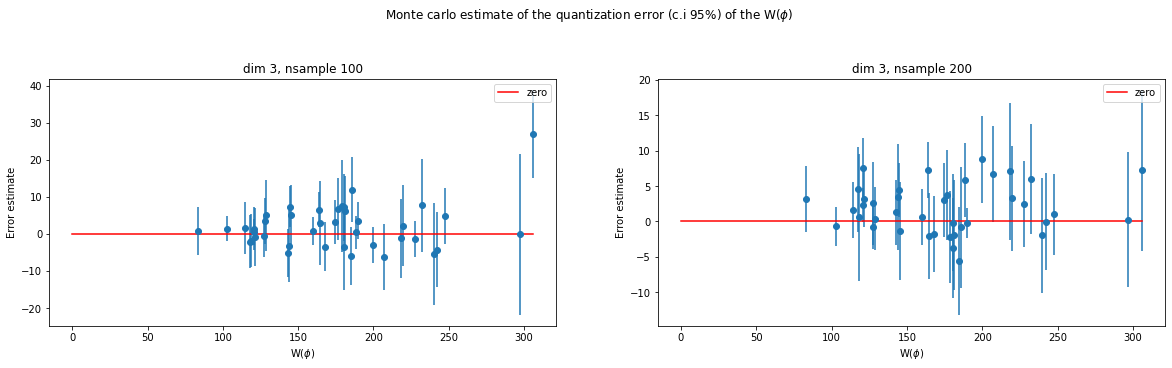

In [ ]:
fig = plt.figure(figsize=(20,10))
id = 1

for idx,nsamples in enumerate(nsamples_test):
  fig.add_subplot(2,2,id)

  Y = [np.mean(errors[idx][i]) for i in range(ntest)]
  err = np.array([np.std(errors[idx][i])/np.sqrt(niter)*1.96 for i in range(ntest)])

  plt.errorbar(dist, Y, yerr=err, fmt='o')
  plt.plot([0, max(dist)], [0,0], c='r', label="zero")

  plt.xlabel("W($\phi$)")
  plt.ylabel("Error estimate")

  plt.title("dim {}, nsample {}".format(dim, nsamples))
  plt.legend()
  id += 1

plt.suptitle("Monte carlo estimate of the quantization error (c.i 95%) of the W($\phi$)")

plt.show()

**Dim=2**

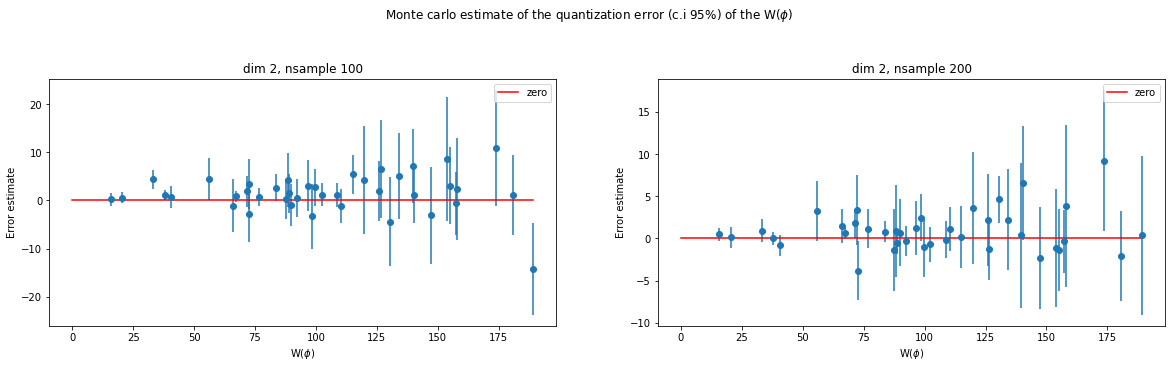

In [ ]:
fig = plt.figure(figsize=(20,10))
id = 1

for idx,nsamples in enumerate(nsamples_test):
  fig.add_subplot(2,2,id)

  Y = [np.mean(errors[idx][i]) for i in range(ntest)]
  err = np.array([np.std(errors[idx][i])/np.sqrt(niter)*1.96 for i in range(ntest)])

  plt.errorbar(dist, Y, yerr=err, fmt='o')
  plt.plot([0, max(dist)], [0,0], c='r', label="zero")

  plt.xlabel("W($\phi$)")
  plt.ylabel("Error estimate")

  plt.title("dim {}, nsample {}".format(dim, nsamples))
  plt.legend()
  id += 1

plt.suptitle("Monte carlo estimate of the quantization error (c.i 95%) of the W($\phi$)")

plt.show()

**Remarks**

*  As expected, the higher the number of samples used to approximated the continuous distribution, the smaller the quantisation error on the Wasserstein distance between a random gaussian dynamics $\mathcal{N}(\mu, \text{diag}(\sigma))$ and the reference dynamics $\mathcal{N}(0_d,I_d)$.

*  We also note that the mean of the error and its standard deviation decrease with the Wasserstein distance. In that sense, the quantization error can be neglected for a small $\epsilon$ in the constraint space: $\mathcal{B}_W(\mathcal{P}_{\phi_0}, \epsilon) = \{\phi \text{ s.t } \mathcal{W}_2^2(\mathcal{P}_\phi, \mathcal{P}_{\phi_0})\leq \epsilon\}$.

*  When the dimension of the problem increases (in our case the dimension f the Gaussian), the Wassertsein distance between randomly picked dynamics and the reference dynamics increases (in fact the number of freedom dregres increase and thus the probability of being close to the reference dynamics becomes low). 

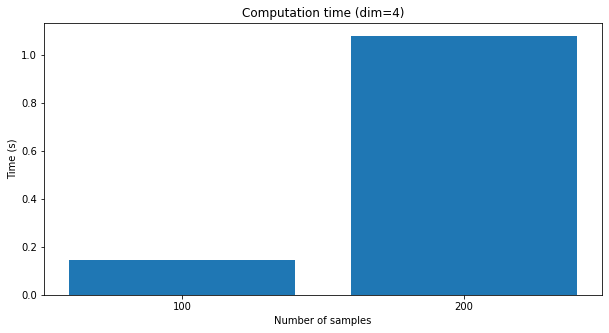

In [ ]:
fig = plt.figure(figsize=(10,5))

plt.bar(range(len(nsamples_test)), [mean(times[idx]) for idx,_ in enumerate(nsamples_test)])
plt.xticks(range(len(nsamples_test)), nsamples_test)
plt.ylabel("Time (s)")
plt.xlabel("Number of samples")
plt.title("Computation time (dim={})".format(dim));

The higher the Wasserstein distance, the higher the quantization error.

##### Display OT

In [ ]:
def display(X0, X, b, b0, scale=10**3):
  #plt.axis("off")

  plt.scatter(X0[0], X0[1], s=b*scale, c='r', label='$P_{\phi_0}$')
  plt.scatter(X[0], X[1], s=b0*scale, c='b', label='$P_\phi$')

  plt.xlim(min(np.min(X[0,:]), np.min(X0[0, :]))-1,max(np.max(X[0,:]), np.max(X0[0, :]))+1)
  plt.ylim(min(np.min(X[1,:]), np.min(X0[1, :]))-1,max(np.max(X[1,:]), np.max(X0[1, :]))+1)
  plt.legend()
  if id != None:
    plt.title("Distributions ")#, fontweight="bold", fontsize=20)

In [ ]:
def display_opt_multivariate(X, X0, b, b0, P_OT, scale=10**3):
  #plt.axis("off")

  plt.scatter(X0[0], X0[1], s=b*scale, c='r', label='$P_{\phi_0}$')
  plt.scatter(X[0], X[1], s=b0*scale, c='b', label='$P_\phi$')

  plt.xlim(min(np.min(X[0,:]), np.min(X0[0, :]))-1,max(np.max(X[0,:]), np.max(X0[0, :]))+1)
  plt.ylim(min(np.min(X[1,:]), np.min(X0[1, :]))-1,max(np.max(X[1,:]), np.max(X0[1, :]))+1)
  plt.legend()

  for i in range(X.shape[1]):
    for j in range(X0.shape[1]):
      if P_OT[i][j] > 1e-5:
        plt.plot([X[0, i], X0[0, j]], [X[1, i], X0[1, j]], c='black', alpha=P_OT[i][j]/b[i, 0])
        
  plt.title("Optimal push forward operator");

Approximated Wasserstein distance: 283.71371


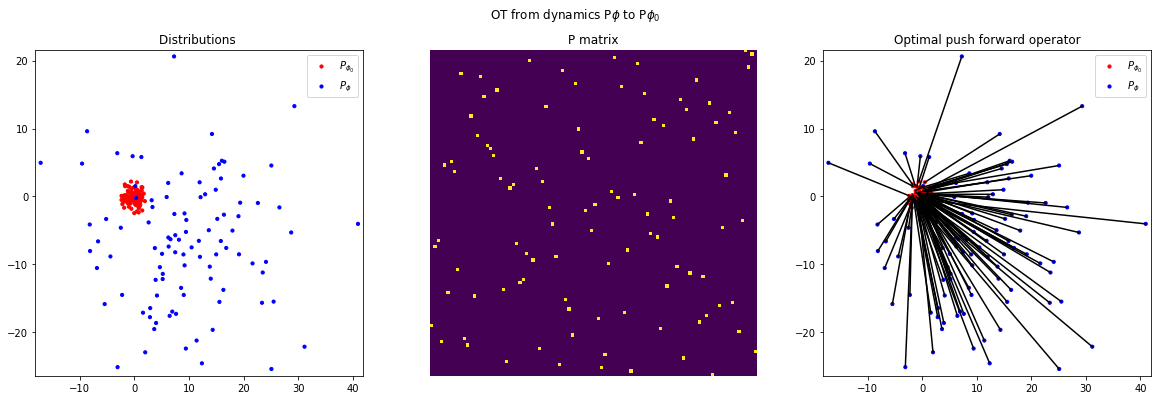

In [ ]:
fig = plt.figure(figsize=(20,6))

fig.add_subplot(1,3,1)
display(X0.T, X.T, b, b0)

fig.add_subplot(1,3,2)
plt.imshow(P_OT.value)
plt.title("P matrix")
plt.axis(False)

fig.add_subplot(1,3,3)
display_opt_multivariate(X.T, X0.T, b, b0, P_OT.value)

plt.suptitle("OT from dynamics P$\phi$ to P$\phi_0$")
print("Approximated Wasserstein distance:", np.round(obj, 5))

In [ ]:
phi_x

array([[ 8.83486778],
       [-5.96093531],
       [ 8.8890662 ],
       [ 9.70092636]])

##### Reward function

##### Zero order approximation of the Hessian 

$$ 
H_0
= \frac{1}{\sigma^2}\mathbb{E}_{\xi \sim \mathcal{N}(0, \sigma^2I)}\left[\frac{1}{\sigma^2}\xi (W(\phi_0 + \xi))\xi^T - W(\phi_0+\xi)I
\right]
$$


### Analytic results

$$
W(\phi)=||\phi - \phi_0||_2
$$
where $\phi=(\mu, \sigma) \in \mathbb{R}^{2d}$

**Gradient**

$
\nabla_\phi W(\phi) = 2(\phi - \phi_0)
$

**Hessian**

$
\nabla^2_\phi W(\phi) = 2\times I_{2d}
$

In [ ]:
H_0 = 2 * np.identity(2*dim)

### Zero-order Approximation

$$ 
H_0
= \frac{1}{\sigma^2}\mathbb{E}_{\xi \sim \mathcal{N}(0, \sigma^2I)}\left[\frac{1}{\sigma^2}\xi (W(\phi_0 + \xi))\xi^T - W(\phi_0+\xi)I
\right]
$$


In [ ]:
def H_zero(sigma, W_function, niter1=100):
  E_xi = 0
  start = time()
  for n  in range(niter1):
    #if n%10==0: print("step", n, np.round(time() - start, 2))
    xi = np.random.normal(0, sigma, phi_0.shape).reshape(2*dim, 1)
    
    w = W_function(phi_0 + xi)
    E_xi += w * (1./sigma**2 * xi @ xi.T - np.identity(2*dim))
  return 1./sigma**2 * E_xi/niter1

##### Approximation error evaluation

**Zero-order approximation**

In [ ]:
sigma = 0.1
H_ZO = H_zero(sigma, W_phi, niter1=1000)
print()
print(H_ZO)
print("Error:", np.round(np.linalg.norm(H_ZO - H_0), 4))

100%|██████████| 1000/1000 [00:00<00:00, 31309.65it/s]


[[ 2.43176923  0.1815567  -0.23165311 -0.32383942]
 [ 0.1815567   3.09602508  0.26168377  0.00622946]
 [-0.23165311  0.26168377  1.67854589 -0.27332474]
 [-0.32383942  0.00622946 -0.27332474  1.83417915]]
Error: 1.4792


In [ ]:
sigma_test = [0.05, 0.1, 1., 2., 5., 15., 100.]
niter = 10000
ntest = 20

err_HZO = [[] for _ in sigma_test]

for idx,sigma in enumerate(sigma_test):
  print(sigma)
  for _ in range(ntest):
    H_ZO = H_zero(sigma, W_phi, niter1=niter)
    err_HZO[idx].append(np.linalg.norm(H_ZO - H_0))


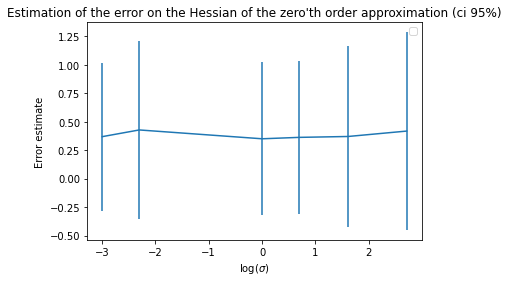

In [ ]:
Y = [mean(err_HZO[idx]) for idx in range(len(sigma_test))]
err_y = [np.std(err_HZO[idx])*1.96*np.sqrt(ntest) for idx in range(len(sigma_test))]

plt.errorbar(np.log(sigma_test), Y, yerr=err_y)
plt.xlabel("log($\sigma$)")
plt.ylabel("Error estimate")

plt.title("Estimation of the error on the Hessian of the zero'th order approximation (ci 95%)")
plt.legend();

**Error as a function of sigma**

In [ ]:
sigma_test = [0.05, 0.1, 1., 2., 5., 15., 100.]
nsamples = 100
ntest = 40

err_term = [[] for _ in sigma_test]
err_w = [[] for _ in sigma_test]

for idx,sigma in enumerate(sigma_test):
  print(sigma)
  for _ in range(ntest):
    xi = np.random.normal(0, sigma, phi_0.shape).reshape(2*dim, 1)
    w = W_Discrete(phi_0 + xi, n=nsamples)
    term = w * (1./sigma**2 * xi @ xi.T - np.identity(2*dim))

    true_w = W_phi(phi_0 + xi)
    true_term = true_w * (1./sigma**2 * xi @ xi.T - np.identity(2*dim))

    err_term[idx].append(1/sigma**2 * np.linalg.norm(term - true_term))
    err_w[idx].append(np.linalg.norm(w-true_w))


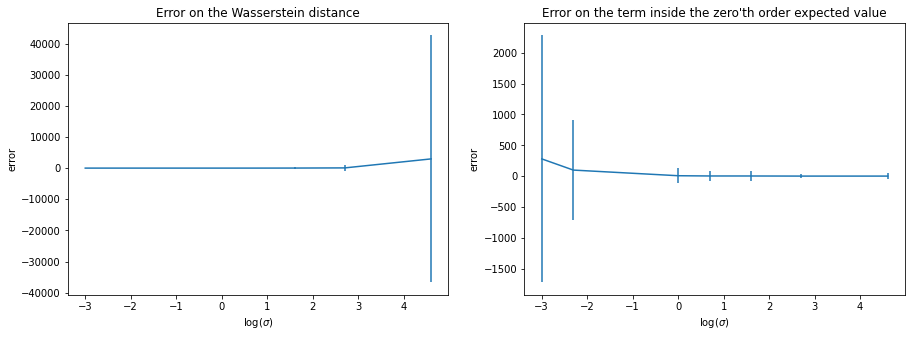

In [ ]:
fig = plt.figure(figsize=(15,5))

fig.add_subplot(1,2,1)
Y = [mean(err_w[idx]) for idx in range(len(sigma_test))]
err_y = [np.std(err_w[idx])*1.96*np.sqrt(ntest) for idx in range(len(sigma_test))]

plt.errorbar(np.log(sigma_test[:]), Y, yerr=err_y)
plt.xlabel("log($\sigma$)")
plt.ylabel("error")
plt.title("Error on the Wasserstein distance")

fig.add_subplot(1,2,2)
Y = [mean(err_term[idx]) for idx in range(len(sigma_test))]
err_y = [np.std(err_term[idx])*1.96*np.sqrt(ntest) for idx in range(len(sigma_test))]

plt.errorbar(np.log(sigma_test[:]), Y, yerr=err_y)
plt.xlabel("log($\sigma$)")
plt.ylabel("error")
plt.title("Error on the term inside the zero'th order expected value");

**Zero-order + quantization approximation**

In [ ]:
sigma = 200.
H_ZOQ = H_zero(sigma, lambda x: W_Discrete(x, n=50), niter1=100)
print()
print(H_ZOQ)
print("Error:", np.round(np.linalg.norm(H_ZOQ - H_0), 4))

In [ ]:
sigma_test = [0.05, 0.1, 1., 2., 5., 15., 100.]
niter = 100
ntest = 10

err_ZOQ = [[] for _ in sigma_test]

for idx,sigma in enumerate(sigma_test):
  print(sigma)
  for _ in range(ntest):
    H_ZOQ = H_zero(sigma, lambda x: W_Discrete(x, n=100), niter1=niter)
    err_ZOQ[idx].append(np.linalg.norm(H_ZOQ - H_0))


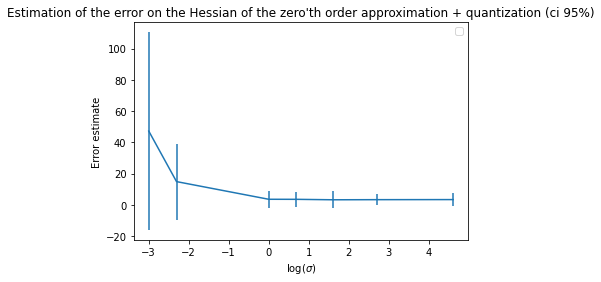

In [ ]:
Y = [mean(err_ZOQ[idx]) for idx in range(len(sigma_test))]
err_y = [np.std(err_ZOQ[idx])*1.96*np.sqrt(ntest) for idx in range(len(sigma_test))]

plt.errorbar(np.log(sigma_test), Y, yerr=err_y)
plt.xlabel("log($\sigma$)")
plt.ylabel("Error estimate")

plt.title("Estimation of the error on the Hessian of the zero'th order approximation + quantization (ci 95%)")
plt.legend();

In [ ]:
sigma = 0.1
ntest = 5

nsamples_test = [50, 100, 150, 200] #, 250, 300]
frob_errors1 = [[] for _ in nsamples_test]
times = [[] for _ in nsamples_test]

for idx,nsamples in enumerate(nsamples_test):
  print(nsamples)
  for _ in range(ntest):
    start = time()

    H_ZOQ = H_zero(sigma, lambda x: W_Discrete(x, n=nsamples), niter1=1000)
    err = np.linalg.norm(H_ZOQ - H_0)

    times[idx].append(time() - start)
    frob_errors1[idx].append(err)

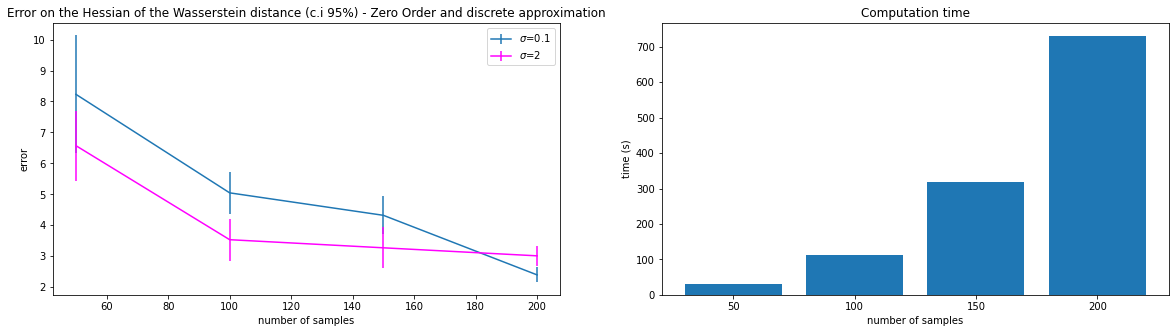

In [ ]:
fig = plt.figure(figsize=(20,5))

fig.add_subplot(1,2,1)

Y = [np.mean(frob_errors[idx]) for idx,_ in enumerate(nsamples_test)]
err = [np.std(frob_errors[idx])/np.sqrt(ntest)*1.96 for idx,_ in enumerate(nsamples_test)]

Y1 = [np.mean(frob_errors1[idx]) for idx,_ in enumerate(nsamples_test)]
err1 = [np.std(frob_errors1[idx])/np.sqrt(ntest)*1.96 for idx,_ in enumerate(nsamples_test)]

plt.errorbar(nsamples_test, Y, yerr=err, label="$\sigma$=0.1")
plt.errorbar(nsamples_test, Y1, yerr=err1, c='magenta', label="$\sigma$=2")
plt.ylabel("error")
plt.xlabel("number of samples")
plt.title("Error on the Hessian of the Wasserstein distance (c.i 95%) - Zero Order and discrete approximation")
plt.legend()

fig.add_subplot(1,2,2)

plt.bar(range(len(nsamples_test)), [mean(times[idx]) for idx,_ in enumerate(nsamples_test)])
plt.xticks(range(len(nsamples_test)), nsamples_test)
plt.xlabel("number of samples")
plt.ylabel("time (s)")
plt.title("Computation time");


## Part II. Application - 1D Geometric law

We consider a simple reinforcement problem on a tabular Markov decision problem with a  final state $s_{final}$ on infinite horizon with discount $\gamma$. This means that
*  the action space $A$ and the state space $S$ are finite and discrete 
*  the transition matrices $P_\phi\in \mathbb{R}^{(S\times A\times S)}$
*  the reward function is 
  $$R(s) = 
\left\{
\begin{array}{l l}
1 & \text{if } s=s_{final}, \\
0 & \text{otherwise}
\end{array}\right.$$
*  the cumulative reward of a trajectory $\tau$ is
$$R_{total}(\tau) = \gamma^{T_\tau} \text{ with } T_\tau = inf\{T \text{, s.t } s_T^\tau=s_{final}\}$$ 

* $A=\{top, bottom, right, left\}$
*  $S=\{(x,y) \text{ for } x\in[1,N], y\in [1,M]\}$
  *  $s_{final}=(N,M)$


* $\mathcal{P}_\phi(s'|s,a) = 
\left\{
\begin{array}{l l}
s + (G,0) & \text{if } a=top, \\
s - (G,0) & \text{if } a=bottom, \\
s + (0,G) & \text{if } a=right, \\
s - (0,G) & \text{if } a=left,
\end{array}\right.$

  with $G\sim \mathcal{G}(1-\phi)$ geometric law of parameter $\phi \in [0,1]$


We set the reference dynamics transition to $\phi_0=0.5$

#### Create RL environment

Tabular MDP of dimension *(N,M)*

In [ ]:
def draw(dist):
    accessible_state = np.where(dist>0)[0]
    r = np.random.uniform()
    for sp in accessible_state[:-1]:
      if np.sum(dist[:sp]) <= r and r <= np.sum(dist[:sp+1]):
        return sp
    return accessible_state[-1]


Compute dynamics $\mathcal{P}_\phi$ for a given $\phi$

In [ ]:
def compute_P(phi, env, tol=0.001):
  M = env.nrows
  N = env.ncols

  states  = [(n,m) for n in range(N) for m in range(M)]

  P = np.zeros((N*M, env.Na, N*M))
  for state in states:
    s = state[0] * M + state[1]
    #print(phi)
    nmax = ceil(np.log(tol/(1-phi))/np.log(phi))
    # top
    a=0
    accessible_states = np.array([n for n in range(state[1], min(M, state[1] + nmax + 1))])
    sp = state[0] * M + accessible_states
    prob = np.array([phi**n*(1-phi) for n in range(sp.shape[0])])
    P[s,a,sp] = prob + (1 - prob.sum())/sp.shape[0]
    # bottom
    a=1
    accessible_states = np.array([n for n in range(max(0, state[1] - nmax), state[1]+1)])
    sp = state[0] * M + accessible_states
    prob = np.flip(np.array([phi**n*(1-phi) for n in range(sp.shape[0])]))
    P[s,a,sp] = prob + (1 - prob.sum())/sp.shape[0]
    #right
    a=2
    accessible_states = np.array([n for n in range(state[0], min(N, state[0] + nmax + 1))])
    sp = accessible_states * M + state[1]
    prob = np.array([phi**n*(1-phi) for n in range(sp.shape[0])])
    P[s,a,sp] = prob + (1 - prob.sum())/sp.shape[0]
    #left
    a=3
    accessible_states = np.array([n for n in range(max(0, state[0] - nmax), state[0] + 1)])
    sp = accessible_states * M + state[1]
    prob = np.flip(np.array([phi**n*(1-phi) for n in range(sp.shape[0])]))
    P[s,a,sp] = prob + (1 - prob.sum())/sp.shape[0]
  return P

In [ ]:
class tabular_env():
  
  # tabular
  max_time = 0
  ncols = 0
  nrows = 0
  gamma = 0

  # states-actions
  Na = 4
  name_actions = ["top", "bottom", "right", "left"]
  final_state = None
  final_reward = 1
  init_state = None

  def init(self):
    # states
    self.Ns = self.ncols * self.nrows

    # dynamics
    self.P = np.zeros((self.Ns, self.Na, self.Ns))

    # rewards
    self.R = np.zeros((self.Ns, self.Na))
    self.R[self.final_state, :] = self.final_reward * np.ones(self.Na)

  def init_dynamics(self, phi_0, sigma_0):
    self.phi_0 = phi_0
    self.P_0 = compute_P(phi_0, self)
    self.sigma_0 = sigma_0
    self.all_phi = np.random.normal(phi_0, sigma_0, self.max_time).clip(0., 1.)
    self.P = []
    for t in range(self.max_time):
      self.P.append(compute_P(self.all_phi[t], self))

  def next_state(self, t, s, a):
    if t == -1:
      return draw(env.P_0[s,a,:])
    else:
      return draw(env.P[t][s,a,:])

  def ind2coord(self, id):
    x = id // self.nrows
    y = id - x*self.nrows
    return (x, y)

  def coord2ind(self, coord):
    return coord[0]*self.nrows + coord[1]

##### Initialize RL system

In [ ]:
env = tabular_env()

# Horizon
env.max_time = 400
env.gamma = 0.9

# Dimensions
env.ncols = 10
env.nrows = 20

# final state 
env.final_state = env.coord2ind((env.ncols-1, env.nrows-1))
# init state
env.init_state = env.coord2ind((0, 0))

env.init()

# Dynamics
phi_0 = 0.5
sigma_0 = 0.1

env.init_dynamics(phi_0, sigma_0)

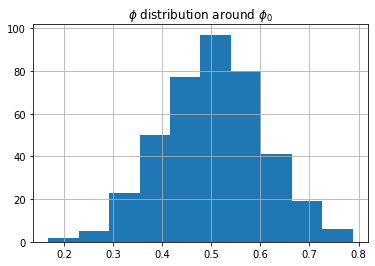

In [ ]:
counts, bins = np.histogram(env.all_phi)
plt.hist(bins[:-1], bins, weights=counts)
plt.grid(True)
plt.title("$\phi$ distribution around $\phi_0$");

##### Display dynamics

In [ ]:
def display(P, N=env.ncols, M=env.nrows):
  im = np.zeros((N,M))
  for x in range(N*M):
    i = x//M
    j = x - i*M
    im[i,j] = P[x]
  plt.imshow(im, label="probability distribution");

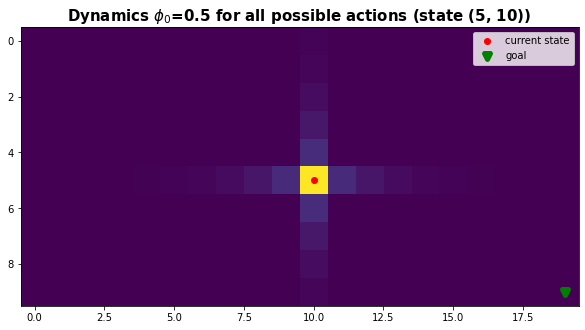

In [ ]:
fig = plt.figure(figsize=(10,10))
state = (env.ncols//2, env.nrows//2)
s = env.coord2ind(state)

display(env.P_0[s,:,:].sum(axis=0));
plt.scatter(state[1], state[0], c='red', label="current state")

goal = env.ind2coord(env.final_state)
plt.scatter(goal[1], goal[0], c='green', marker="v", label="goal", linewidths=5)

plt.legend()
plt.title("Dynamics $\phi_0$={} for all possible actions (state {})".format(phi_0, state), fontweight="bold", fontsize=15);

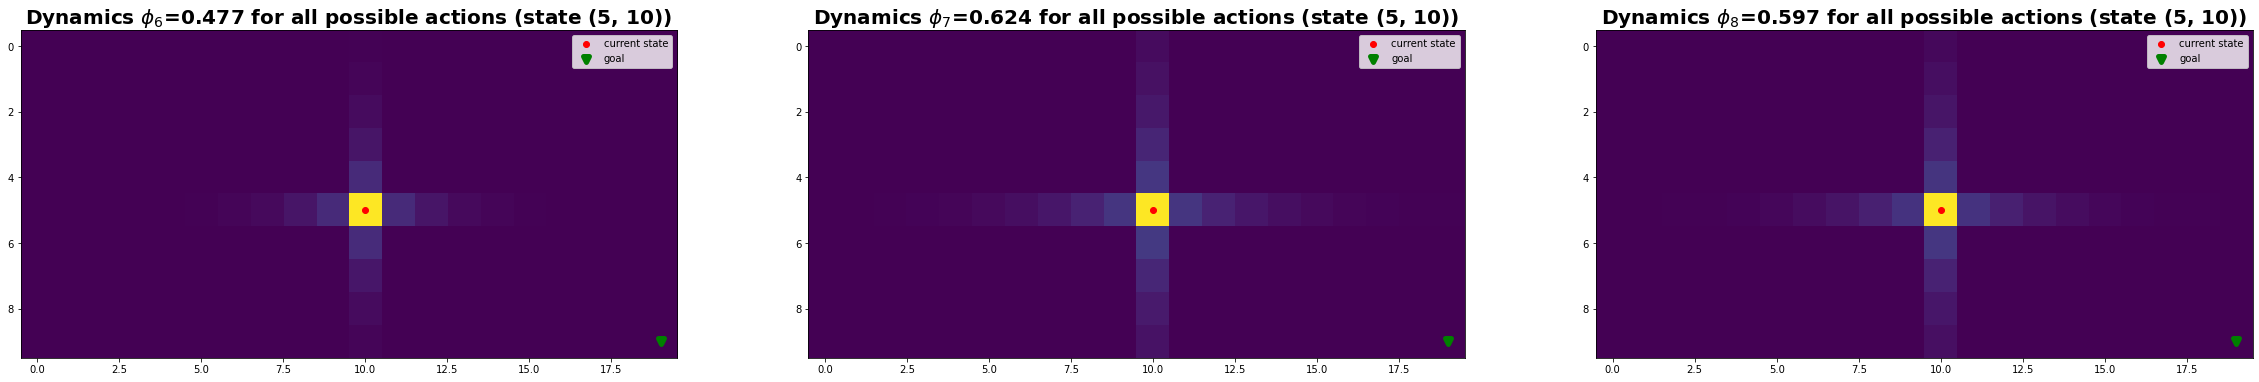

In [ ]:
fig = plt.figure(figsize=(40,30))
id = 1

for t in range(6, 9):
  fig.add_subplot(3,3,id)
  Pt = env.P[t]
  state = (env.ncols//2, env.nrows//2)
  s = env.coord2ind(state)

  display(Pt[s,:,:].sum(axis=0));
  plt.scatter(state[1], state[0], c='red', label="current state")

  goal = env.ind2coord(env.final_state)
  plt.scatter(goal[1], goal[0], c='green', marker="v", label="goal", linewidths=5)

  plt.legend()
  plt.title("Dynamics $\phi_{}$={} for all possible actions (state {})".format(t, np.round(env.all_phi[t], 3), state), fontweight="bold", fontsize=20)
  id += 1
plt.show()

$ \mathcal{W}_{(s,a)}(\phi) = \mathcal{W}^2_2 \left( \mathcal{P}_\phi(.|s,a),
\mathcal{P}_{\phi_0}(.|s,a)\right) $

In [ ]:
def W(s, a, P, P_0, env=env):
  # Measures
  X = np.array([np.where(P[s,a,:]>0)[0]])
  b = P[s,a,X]
  X = np.vstack(env.ind2coord(X))

  X0 = np.array([np.where(P_0[s,a,:]>0)[0]])
  b0 = P_0[s,a,X0]
  X0 = np.vstack(env.ind2coord(X0))
  _, obj = solve(X, X0, b.T, b0.T)
  return obj

##### Example on a pair *(state,action)*

In [ ]:
# time
t = 0
P = env.P[t]

# state
state = (env.ncols//2, 0)
s = env.coord2ind(state)
# action
a = 0 #top

# Measures
X = np.array([np.where(P[s,a,:]>0)[0]])
b = P[s,a,X]
X = np.vstack(env.ind2coord(X))

X0 = np.array([np.where(env.P_0[s,a,:]>0)[0]])
b0 = env.P_0[s,a,X0]
X0 = np.vstack(env.ind2coord(X0))

In [ ]:
P_OT, obj = solve(X, X0, b.T, b0.T, LOG=True)

(n,m): (11,10)
Number of non-zero: 20 (n + m-1 = 20)


In [ ]:
def display_opt(X, X0, b, b0, P_OT, env=env, t=t, scale=700):
  plt.scatter(np.zeros(X[0].shape), X[1], s=b * scale, label="$\phi$={}".format(np.round(env.all_phi[t], 3)))
  plt.scatter(np.ones(X0[0].shape), X0[1], s=b0 * scale, c='r', label="$\phi_0$={}".format(env.phi_0))
  plt.axis(False)

  for i in range(X.shape[1]):
    for j in range(X0.shape[1]):
      if P_OT[i][j] > 1e-5:
        plt.plot([0,1], [X[1][i], X0[1][j]], c='black', alpha=P_OT[i][j]/b[0][i])
  
  plt.ylim(min(np.min(X0[1,:]), np.min(X[1, :])) - 1, max(np.max(X0[1,:]), np.max(X[1, :])) + 1)
  plt.xlim(-0.5, 1.5)
  plt.legend();

Wasserstein distance: 0.16829


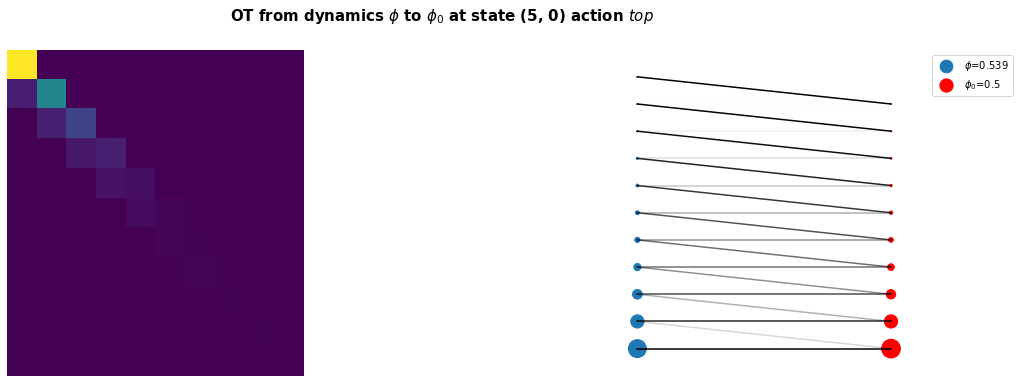

In [ ]:
fig = plt.figure(figsize=(20,6))

fig.add_subplot(1,2,1)
plt.imshow(P_OT.value)
plt.axis(False)

fig.add_subplot(1,2,2)
display_opt(X, X0, b, b0, P_OT.value)

plt.suptitle("OT from dynamics $\phi$ to $\phi_0$ at state {} action ${}$".format(state, env.name_actions[a]), fontweight="bold", fontsize=15)
print("Wasserstein distance:", np.round(obj, 5))

##### Create trajectory datasets

In [ ]:
def draw_trajectory(policy, P=np.array([[[None]]]), env=env):
  trajectory = []
  actions = []

  s = env.init_state
  trajectory.append(s)
  for tt in range(0, env.max_time):
    
    a = draw(policy[s])
    if P[0,0,0]==None:
      # system's dynamics
      sp = env.next_state(tt,s,a)
    else:
      # dynamics at time t
      sp = draw(P[s,a,:])
    
    s = sp
    actions.append(a)
    trajectory.append(s)

    if s == env.final_state: break
  return trajectory, actions

In [ ]:
NaivePolicy = np.zeros((env.Ns, env.Na))

for s in range(env.Ns):
  state = env.ind2coord(s)
  if state[1]==env.nrows-1:
    NaivePolicy[s, 2] = 1.
  elif state[0]==env.ncols-1:
    NaivePolicy[s, 0] = 1.
  else:
    NaivePolicy[s, 0] = 0.5
    NaivePolicy[s, 2] = 0.5

##### Display trajectory

In [ ]:
trajectory, actions = draw_trajectory(NaivePolicy)

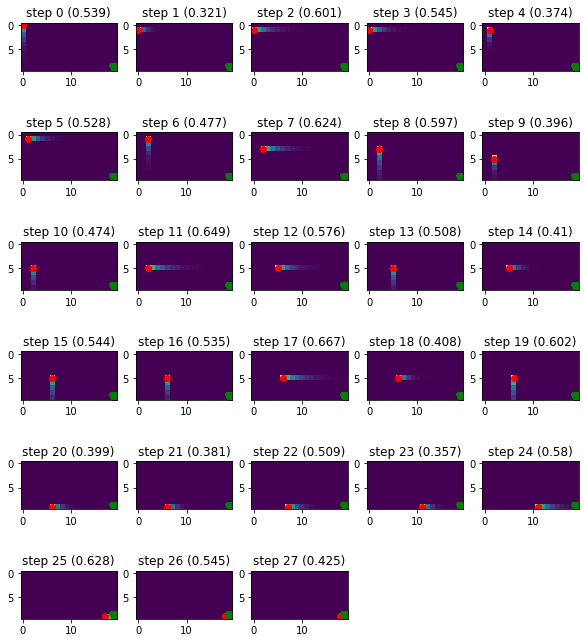

In [ ]:
im = np.zeros((env.ncols, env.nrows))

fig = plt.figure(figsize=(10,40))
id = 1

for t,s in enumerate(trajectory[:-1]):
  state = env.ind2coord(s)
  fig.add_subplot(20,5,id)
  plt.scatter(state[1], state[0], c='red', label="current state")

  display(env.P[t][s,actions[t],:])

  goal = env.ind2coord(env.final_state)
  plt.scatter(goal[1], goal[0], c='green', marker="v", label="goal", linewidths=5)
  plt.title("step {} ({})".format(t, np.round(env.all_phi[t], 3)))
  id += 1

##### Expected Wasserstein distance $\mathbb{E}_{(s,a)\sim\pi(.)\rho^{\phi_0}_{\pi}(.)}[\mathcal{W}_{(s,a)}(\phi)]$

*  We create a batch of **trajectories** sampled from the **uniform over actions policy** $\pi_u$ (the trajectory can have different lenght as the trajectory finishes when the agent reach the goal)
* From the batch of trajectories, we create a bucket of **state-actions pairs** 
* Given such data, we then compute **expected Wasserstein** distance over the pairs
using Monte-Carlo estimation


In [ ]:
UniformPolicy = 1/env.Na * np.ones((env.Ns, env.Na))

In [ ]:
n_traj = 1000

# Batch of trajectories from the uniform policy
BatchUniform_states = []
BatchUniform_actions = []

start = time()
for n in range(n_traj):
  #if n%1000 == 0: print("step", n)
  states, actions = draw_trajectory(UniformPolicy, P=env.P_0)
  BatchUniform_states.append(states)
  BatchUniform_actions.append(actions)
print("{}s to create the dataset of {} trajectories sampled from the uniform policy".format(np.round(time() - start, 2), n_traj))

24.71s to create the dataset of 1000 trajectories sampled from the uniform policy


In [ ]:
# Bucket of state-action pair
BucketUniform_sa = []

start = time()
for n in range(n_traj):
  BucketUniform_sa = BucketUniform_sa + list(zip(BatchUniform_states[n], BatchUniform_actions[n]))
print("{}s to extract the bucket of {} state-action pairs".format(np.round(time() - start, 2), len(BucketUniform_sa)))

3.25s to extract the bucket of 342940 state-action pairs


Our problem evolve in very small dimensions ($\phi \in [0,1]$). As a consequence, te ball on the expected Wasserstein distance between any dynamics $\mathcal{P}_\phi$ and the reference dynamics $\mathcal{P}_{\phi_0}$ can be directly computed without the second order Taylor expansion.



**Wasserstein $\epsilon$ ball**

$\{ \phi \text{ s.t }
\underbrace{ \mathbb{E}_{(s,a)\sim\pi(.) \rho_\pi^{\phi_0}(.)} \left[\mathcal{W}^2_2 \left( \mathcal{P}_\phi(.|s,a), \mathcal{P}_{\phi_0}(.|s,a) \right) \right]}_{W(\phi)} \leq \epsilon
\}$

In [ ]:
def W_exp(phi, dataset, niter=100, env=env):
    E_sa = 0
    random_idx = np.random.randint(0, len(dataset), niter)
    for idx in random_idx:
      (s,a) = dataset[idx]
      P = compute_P(phi, env)
      w = W(s, a, P, env.P_0, env=env)
      E_sa += w
    E_sa = E_sa/niter
    return E_sa

In [ ]:
niter_test = [10, 100, 300, 1000]
nvar = 5
phi_test = np.linspace(0.1,0.9,9)

dist = [[[] for _ in phi_test] for _ in niter_test]

for idx,niter in enumerate(niter_test):
  for i,phi in enumerate(phi_test):
    for n in range(nvar):
      dist[idx][i].append(W_exp(phi, BucketUniform_sa, niter=niter, env=env))

In [ ]:
fig = plt.figure(figsize=(20,5))
id = 1

Y = [[] for _ in niter_test]
err = [[] for _ in niter_test]

for idx,niter in enumerate(niter_test):
  fig.add_subplot(1,len(niter_test),id)

  Y[idx] = [np.mean(dist[idx][i]) for i in range(len(phi_test))]
  err[idx] = np.array([np.std(dist[idx][i])/np.sqrt(nvar)*1.96 for i in range(len(phi_test))])

  plt.errorbar(phi_test, Y[idx], yerr=err[idx])

  plt.xlabel("$\phi$")
  plt.ylabel("Estimate")
  plt.suptitle("Monte carlo estimate (c.i 95%) of the W($\phi$)")
  plt.title("{} iterations".format(niter))

  id += 1

**Remark** on can directly find on the plot the minimizer $\phi$ of the problem for a given robustness parameter $\epsilon$

##### Second order Taylor expansion


*  Zero-order Hessian estimate


  $$ 
  H_0
  = \frac{1}{\sigma^2}\mathbb{E}_{\xi \sim \mathcal{N}(0, \sigma^2I)}\left[\frac{1}{\sigma^2}\xi (\mathbb{E}_{(s,a)\sim\pi(.)\rho^{\phi_0}_{\pi}(.)}[\mathcal{W}_{(s,a)}(\phi_0 + \xi)])\xi^T - \mathbb{E}_{(s,a)\sim \pi(.)\rho^{\phi_0}_\pi(.)}[\mathcal{W}_{(s,a)}(\phi_0+\xi)]I
  \right]
  $$

In [ ]:
# Monte-Carlo estimate of the Hessian of the expected Wasserstein distance

def H_zero(sigma, dataset, env, niter1=100, niter2=100):
  E_xi = 0
  start = time()
  for n  in range(niter1):
    if n%10==0: print("step", n, np.round(time() - start, 2))
    xi = np.random.normal(0, sigma, 1)[0] #phi_0.shape)
    
    E_sa = W_exp((phi_0 + xi).clip(0,1), dataset, niter=niter2, env=env)

    E_xi += 1./sigma**2 * xi * E_sa * xi.T - E_sa * np.identity(1) #phi_0.shape[0])
  return 1./sigma**2 * E_xi/niter1

In [ ]:
niter1 = 100 #1000
niter2 = 200

start = time()
H_0 = H_zero(0.1, BucketUniform_sa, env, niter1=niter1, niter2=niter2)
print("{}s to compute the zero-order estimation of H_0 (niter1={}, niter2={} iterations)".format(np.round(time() - start, 2), niter1, niter2))

In [ ]:
H_0

array([[65.66126102]])

In [ ]:
sigma_test = [0.07] #[0.05, 0.07, 0.1]
Hessian_list = []

niter1 = 1000
niter2 = 200

for sigma in sigma_test:
  H_0 = H_zero(sigma, BucketUniform_sa, env, niter1=niter1, niter2=niter2)
  Hessian_list.append(H_0)

In [ ]:
H_0

array([[51.79291576]])

In [ ]:
print("Zero-order hessian estimate for phi={}")
print()
print("sigma   ", "hessian estimate")
for idx,sigma in enumerate(sigma_test):
  print('{}      {}'.format(sigma, Hessian_list[idx]))

*  Zero-Order Gradient Estimate

  $$g_j = \frac{1}{\sigma^2}\mathbb{E}_{\xi \sim \mathcal{N}(0,\sigma^2I)}\left[\xi \underbrace{\int_\tau p_\theta^{\phi_j + \xi}(\tau)R_{total}(\tau)d\tau}_{\mathbb{E}_{\tau \sim p_\theta^{\phi_j + \xi}(.)}[R_{total}(\tau)]} \right]$$

$\mathbb{E}_{\tau \sim p_\theta^{\phi_j + \xi}(.)}[R_{total}(\tau)]$

In [ ]:
def E_reward(P, env=env, niter=1000):
  E = 0

  for n in range(niter):
    #if n%1000 == 0: print("step", n)
    states, _ = draw_trajectory(NaivePolicy, P=P)
    E = E + env.gamma**(len(states))

  return E/niter

In [ ]:
niter = 1000
nvar=5
phi_test = np.linspace(0.1,0.9,9)
R = [[] for _ in phi_test]

for idx,phi in enumerate(phi_test):
  P = compute_P(phi, env=env)
  for _ in range(nvar):
    R[idx].append(E_reward(P, env=env, niter=niter))

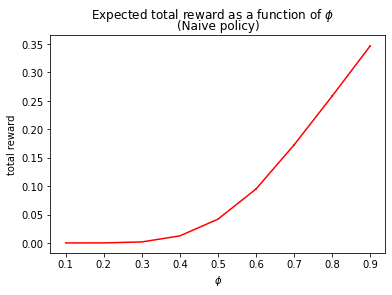

In [ ]:
Y = [np.mean(R[i]) for i in range(len(phi_test))]
err = [np.std(R[i])/np.sqrt(nvar) * 1.96 for i in range(len(phi_test))]

plt.errorbar(phi_test, Y, yerr=err, c='r')
plt.suptitle("Expected total reward as a function of $\phi$")
plt.title("(Naive policy)")
plt.xlabel("$\phi$")
plt.ylabel("total reward");

**Remark**: as expected, the reward increses when $\phi$ inscreases. In fact, the reward is big if the time to reach the goal is small and with higher parameter $\phi$, the displacements inside the RL environment are bigger. Hence the smaller time to reach the goal and the higher reward.

$1000$ iterations leads to verry small $95\%$ confidence intervals.

In [ ]:
def gradient(phi, sigma, env=env, niter1=1000, niter2=1000):
  g = 0
  for _ in range(niter1):
    xi = np.random.normal(0, sigma, 1)[0]
    P = compute_P((phi + xi).clip(0,1), env=env)
    g = g + xi * E_reward(P, env=env, niter=niter2)
  return 1/sigma**2 * g/niter1

In [ ]:
sigma_test = [0.05, 0.07, 0.1]
grad = []

phi = 0.6
niter1 = 1000
niter2 = 1000

for sigma in sigma_test:
  grad.append(gradient(phi, sigma, niter1=niter1, niter2=niter2))

In [ ]:
print("Zero-order gradient estimate for phi={}".format(phi))
print()
print("sigma   ", "gradient estimate")
for idx,sigma in enumerate(sigma_test):
  print('{}      {}'.format(sigma, grad[idx]))

Zero-order gradient estimate for phi=0.6

sigma    gradient estimate
0.05      0.6967616160109139
0.07      0.6003656854730639
0.1      0.5951957806089275


Closed form solution

  $$\phi_{j+1}=\phi_0 - \sqrt{\frac{2\epsilon}{g_j^T H_0^{-1}g_j}}H_0^{-1}g_j$$

In [ ]:
phi_j = 0.6
epsilon = 1.4

g_j = 0.5456
H_0 = 65.66126102

phi_opt = env.phi_0 - np.sqrt(2*epsilon / (g_j**2 *  1/H_0)) * 1/H_0 * g_j

In [ ]:
phi_opt

0.2934979315664695

In [ ]:
W_exp(phi_opt, BucketUniform_sa, niter=1000, env=env)

0.5923635716819263

In [ ]:
eps_test = [0.1, 0.5, 1, 1.5]
sigma = 0.1
niter1 = 1 #500
niter2 = 1000
niter3 = 200
phi = 0.6

sigma_test = [0.05, 0.07, 0.1]

phi_opt_list = [[] for _ in sigma_test]
err_eps = [[] for _ in sigma_test]

grad_test = []
Hessian_test = []

#sigma=0.05
g_j = 0.6967616160109139
H_0 = 44.71845729
grad_test.append(g_j)
Hessian_test.append(H_0)
#sigma=0.07
g_j = 0.6003656854730639
H_0 = 51.79291576
grad_test.append(g_j)
Hessian_test.append(H_0)
#sigma=0.1
g_j = 0.5951957806089275
H_0 = 65.66126102
grad_test.append(g_j)
Hessian_test.append(H_0)

for id,_ in enumerate(sigma_test):
  H_0 = Hessian_test[id]
  g_j = grad_test[id]
  print(g_j, H_0)
  for _,eps in enumerate(eps_test):
    print("eps", eps, "H_0", H_0)

    phi_opt = env.phi_0 - np.sqrt(2*eps / (g_j**2 *  1/H_0)) * 1/H_0 * g_j

    phi_opt_list[id].append(phi_opt)
    err_eps[id].append(np.abs(W_exp(phi_opt, BucketUniform_sa, niter=1000, env=env)-eps))

0.6967616160109139 44.71845729
eps 0.1 H_0 44.71845729
eps 0.5 H_0 44.71845729
eps 1 H_0 44.71845729
eps 1.5 H_0 44.71845729
0.6003656854730639 51.79291576
eps 0.1 H_0 51.79291576
eps 0.5 H_0 51.79291576
eps 1 H_0 51.79291576
eps 1.5 H_0 51.79291576
0.5951957806089275 65.66126102
eps 0.1 H_0 65.66126102
eps 0.5 H_0 65.66126102
eps 1 H_0 65.66126102
eps 1.5 H_0 65.66126102


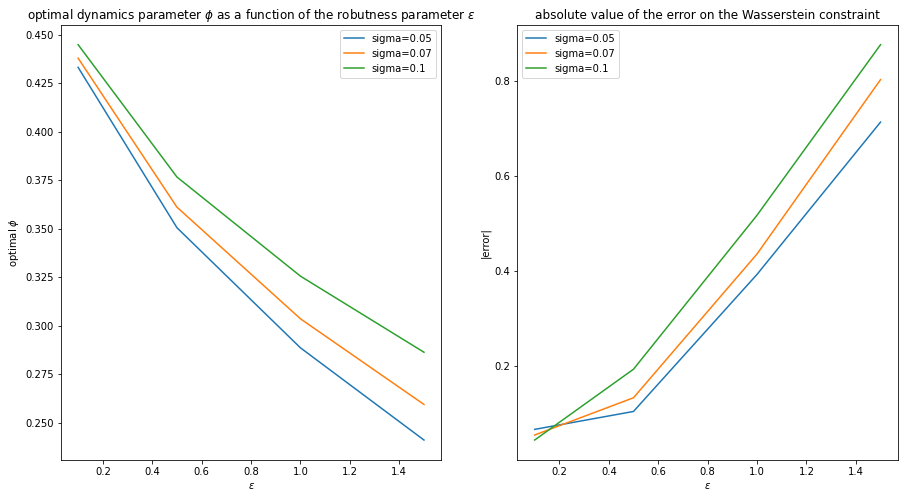

In [ ]:
fig = plt.figure(figsize=(15,8))

fig.add_subplot(1,2,1)
for idx,sigma in enumerate(sigma_test):
  plt.plot(eps_test, phi_opt_list[idx], label="sigma={}".format(sigma))
plt.title("optimal dynamics parameter $\phi$ as a function of the robutness parameter $\epsilon$")
plt.xlabel("$\epsilon$")
plt.ylabel("optimal $\phi$")
plt.legend();
 

fig.add_subplot(1,2,2)
for idx,sigma in enumerate(sigma_test):
  plt.plot(eps_test, err_eps[idx], label="sigma={}".format(sigma))
plt.title("absolute value of the error on the Wasserstein constraint")
plt.xlabel("$\epsilon$")
plt.ylabel("|error|")
plt.legend();

In [ ]:
#sigma=0.1
g_j = 0.5951957806089275
H_0 = 65.66126102
#sigma=0.05
g_j = 0.6967616160109139
H_0 = 44.71845729
#sigma=0.07
g_j = 0.6003656854730639
H_0 = 51.79291576